In [87]:
%cd ../pytorch/;

[Errno 2] No such file or directory: '../pytorch/;'
/home/tony/predicting-poverty/pytorch


In [2]:
% matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.autograd import Variable
from torchvision import transforms
from load_dataset import BangladeshDataset, IndiaDataset
from sklearn import metrics

In [6]:
folder_name = "india_s1_2015"
sat_type = "Sentinel-1"

Loss plots

In [7]:
losses = {
  "train": np.load("/home/tony/models/{}/losses_train.npy".format(folder_name)),
  "val": np.load("/home/tony/models/{}/losses_val.npy".format(folder_name))
}
rsq = {
  "train": np.load("/home/tony/models/{}/rsq_train.npy".format(folder_name)),
  "val": np.load("/home/tony/models/{}/rsq_val.npy".format(folder_name))
}

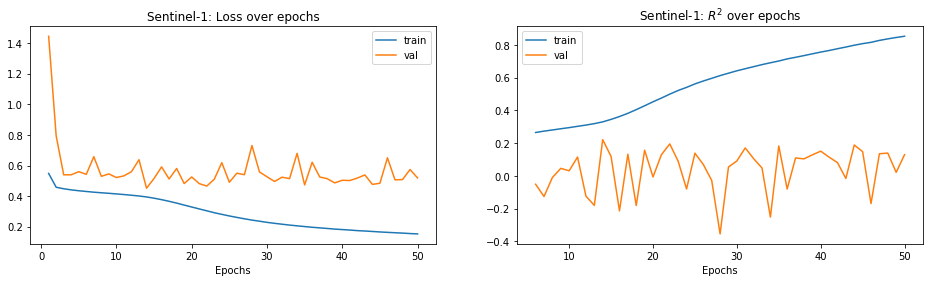

In [8]:
N = len(np.array(losses["train"]))
rsq_cutoff = 5
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, N+1), np.array(losses["train"]), label="train")
plt.plot(np.arange(1, N+1), np.array(losses["val"]), label="val")
plt.title("{}: Loss over epochs".format(sat_type))
plt.xlabel("Epochs")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.arange(rsq_cutoff + 1, len(rsq["train"]) + 1), np.array(rsq["train"])[rsq_cutoff:], label="train")
plt.plot(np.arange(rsq_cutoff + 1, len(rsq["val"]) + 1), np.array(rsq["val"])[rsq_cutoff:], label="val")
plt.title("{}: $R^2$ over epochs".format(sat_type))
plt.xlabel("Epochs")
plt.legend()

In [9]:
np.argmax(rsq["val"]), np.max(rsq["val"])

(13, 0.22080309951228116)

Predicted versus observed plot.

In [10]:
import seaborn as sns

In [11]:
y_pred = np.load("/home/tony/models/{}/y_pred.npy".format(folder_name))
y_valid = np.load("/home/tony/models/{}/y_true.npy".format(folder_name))

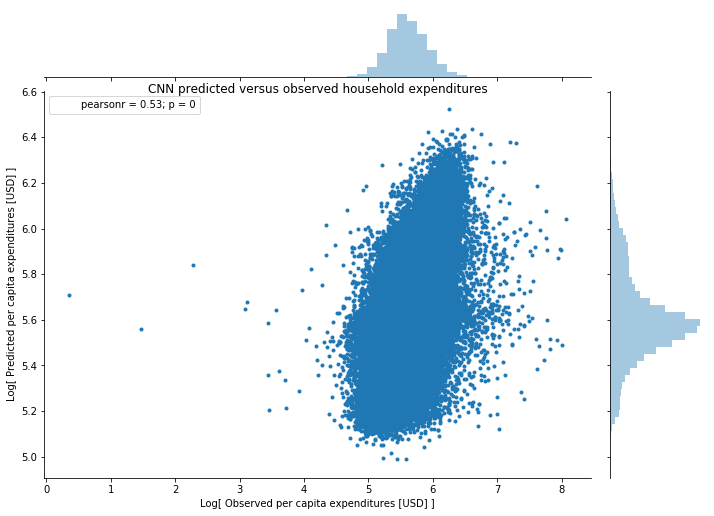

In [12]:
fig = sns.jointplot(np.log(y_valid[np.logical_and(y_valid > 0, y_pred > 0)]), 
                    np.log(y_pred[np.logical_and(y_valid > 0, y_pred > 0)]), 
                    size=8, marker=".")
fig.fig.set_size_inches((10, 7))
fig.ax_joint.set(ylabel="Log[ Predicted per capita expenditures [USD] ]",
                 xlabel="Log[ Observed per capita expenditures [USD] ]")
fig.ax_joint.set_title("CNN predicted versus observed household expenditures", y=0.98);

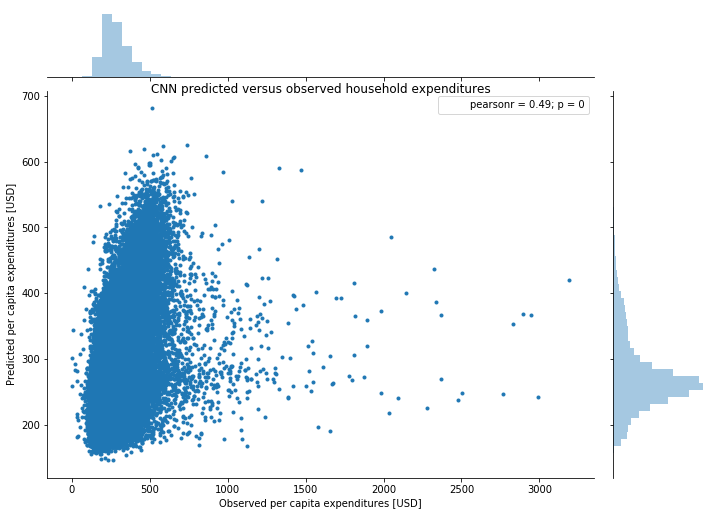

In [13]:
fig = sns.jointplot(y_valid[np.logical_and(y_valid > 0, y_pred > 0)], 
                    y_pred[np.logical_and(y_valid > 0, y_pred > 0)], 
                    size=8, marker=".")
fig.fig.set_size_inches((10, 7))
fig.ax_joint.set(ylabel="Predicted per capita expenditures [USD]",
                 xlabel="Observed per capita expenditures [USD]")
fig.ax_joint.set_title("CNN predicted versus observed household expenditures", y=0.98);

In [14]:
metrics.r2_score(y_valid, y_pred)

0.22080309951228116

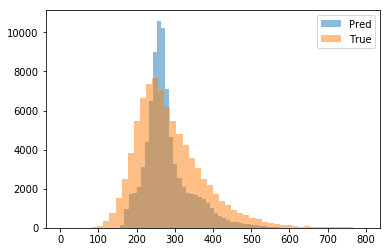

In [15]:
plt.hist(y_pred[y_pred < 800], bins=50, alpha=0.5, label="Pred")
plt.hist(y_valid[y_valid < 800], bins=50, alpha=0.5, label="True")
plt.legend();

In [16]:
model = None

In [17]:
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1)

In [18]:
model.load_state_dict(torch.load("/home/tony/models/{}/saved_model.model".format(folder_name)))

In [19]:
model.train(False);

In [20]:
train_csv_path = "../data/india_train.csv"
val_csv_path = "../data/india_valid.csv"

In [21]:
data_transforms = {
        "train": transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

In [22]:
home_dir = os.path.expanduser("~")

In [23]:
val_data_dir = "{}/tiffs".format(home_dir)

In [24]:
val_dataset = IndiaDataset(csv_file=val_csv_path,
                      root_dir=val_data_dir,
                      transform=data_transforms["val"],
                      sat_type="s1")

In [25]:
len(val_dataset)

84673

In [26]:
finalconv_name = 'layer4'

In [27]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

model._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [28]:
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

=============

In [71]:
def vis_cam(idx):
  
  img, label = val_dataset[idx]
  print("Label:\t", label)
  print("Pred:\t", model(Variable(img.unsqueeze(0))).data[0,0])
  feature_conv = features_blobs[-1]
  bz, nc, h, w = feature_conv.shape
  cam = weight_softmax.dot((feature_conv.reshape((nc, h*w))))
  cam = cam.reshape(h, w)
  cam = cam - np.min(cam)
  cam_img = cam / np.max(cam)
  cam_img = cv2.resize(cam_img, (224, 224))
  plt.imshow(cam_img)
  img_orig = ((img.numpy().transpose(1,2,0) * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]))
  plt.imshow(plt.cm.jet(cam_img)[:,:,:3] * 0.2 + img_orig * 0.8)
  return cam

Label:	 248.534990916
Pred:	 278.10968017578125


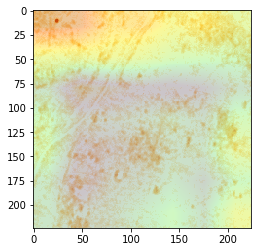

In [86]:
cam = vis_cam(69)

=================